## Generative Latent Replay with GMMs

Code to test latent replay on benchmark problems and compare with proposed generative latent replay strategies i.e. normalising bottleneck representations and sampling from fitted GMM on latent space.

In [1]:
# ML imports
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torchvision import transforms

#from avalanche.training import Naive
from avalanche.models import SimpleMLP #, SimpleCNN
from avalanche.benchmarks.classic import PermutedMNIST #,PermutedOmniglot, RotatedOmniglot

from matplotlib import pyplot as plt

# Local imports
import models
import utils
from nets import SimpleCNN

In [2]:
# Config
device = utils.get_device()

model = 'mlp'

if model=='mlp':
    model = SimpleMLP(input_size=784, hidden_layers=2, num_classes=10)
    penultimate_layer_dim = 512
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: torch.flatten(x))])
    
elif model=='cnn':
    model = SimpleCNN(num_classes=10)
    penultimate_layer_dim = 64
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

else:
    # CL Benchmark Creation
    # Original AR1* usese CORE50 (n,3,128,128) and pretrained mobilenet
    transform = transforms.Compose([
        #transforms.Lambda(lambda x: x.convert('RGB')),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1))
    ])

perm_mnist = PermutedMNIST(n_experiences=3, train_transform=transform, eval_transform=transform)
train_stream = perm_mnist.train_stream
test_stream = perm_mnist.test_stream

# Prepare for training & testing
criterion = CrossEntropyLoss()

# Continual learning strategy
#cl_strategy = models.LatentReplay(criterion, train_mb_size=32, train_epochs=2, eval_mb_size=32, device=device) 
latent_layer_number = 1

cl_strategy = models.AR1(
    model=model, 
    penultimate_layer_dim=penultimate_layer_dim,
    criterion=criterion, 
    train_mb_size=32, 
    train_epochs=5, 
    eval_mb_size=32, 
    latent_layer_num=latent_layer_number, 
    freeze_below_layer=f"lat_features.{latent_layer_number-1}", 
    device=device
    )

# train and test loop over the stream of experiences
results = []

for train_exp in train_stream:
    cl_strategy.train(train_exp)
    results.append(cl_strategy.eval(test_stream))

c:\Users\jacob\Documents\GitHub\generative-latent-replay\models\ar1.py:109: UserWarning: The AR1 strategy implementation is in an alpha stage and is not perfectly aligned with the paper implementation. Please use at your own risk!
  warnings.warn(


MobilenetV1(
  (lat_features): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
  )
  (end_features): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (output): Linear(in_features=512, out_features=10, bias=False)
)
-- >> Start of training phase << --
100%|██████████| 1875/1875 [01:09<00:00, 27.06it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.5477
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5151
100%|██████████| 1875/1875 [00:47<00:00, 39.53it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.5333
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8391
100%|██████████| 1875/1875 [00:46<00:00, 39.95it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.3976
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8838
100%|██████████| 1875

[{'Top1_Acc_Epoch/train_phase/train_stream/Task000': 0.9163166666666667, 'Loss_Epoch/train_phase/train_stream/Task000': 0.28641179114580156, 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000': 0.9391, 'Loss_Exp/eval_phase/test_stream/Task000/Exp000': 0.20574223229438066, 'Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001': 0.1639, 'Loss_Exp/eval_phase/test_stream/Task001/Exp001': 2.4545523601531984, 'Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002': 0.1097, 'Loss_Exp/eval_phase/test_stream/Task002/Exp002': 2.9384113536834717, 'Top1_Acc_Stream/eval_phase/test_stream/Task000': 0.9391, 'Top1_Acc_Stream/eval_phase/test_stream/Task001': 0.1639, 'Top1_Acc_Stream/eval_phase/test_stream/Task002': 0.1097, 'Loss_Stream/eval_phase/test_stream/Task000': 0.20574223229438066, 'Loss_Stream/eval_phase/test_stream/Task001': 2.4545523601531984, 'Loss_Stream/eval_phase/test_stream/Task002': 2.9384113536834717}, {'Top1_Acc_Epoch/train_phase/train_stream/Task000': 0.9163166666666667, 'Loss_Epoch/trai

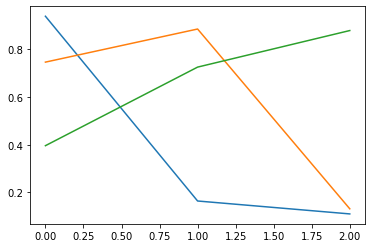

In [6]:
# JA: Next step - replace internal model.
# - model def
# - frozen layer name
# - batch renorm stuff...?

# JA: 2nd step
# - make GMM
# - add GMM to model sampler

results_ar1 = results
print(results_ar1)

['Top1_Acc_Epoch/train_phase/train_stream/Task000', 
 'Loss_Epoch/train_phase/train_stream/Task000',
 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000',
 'Loss_Exp/eval_phase/test_stream/Task000/Exp000',
 'Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001',
 'Loss_Exp/eval_phase/test_stream/Task001/Exp001',
 'Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002',
 'Loss_Exp/eval_phase/test_stream/Task002/Exp002',
 'Top1_Acc_Stream/eval_phase/test_stream/Task000',
 'Top1_Acc_Stream/eval_phase/test_stream/Task001',
 'Top1_Acc_Stream/eval_phase/test_stream/Task002',
 'Loss_Stream/eval_phase/test_stream/Task000',
 'Loss_Stream/eval_phase/test_stream/Task001',
 'Loss_Stream/eval_phase/test_stream/Task002',
 'Top1_Acc_Epoch/train_phase/train_stream/Task001',
 'Loss_Epoch/train_phase/train_stream/Task001',
 'Top1_Acc_Epoch/train_phase/train_stream/Task002',
 'Loss_Epoch/train_phase/train_stream/Task002']

def plotplot(results):
    results_clean = {"train":{'acc':[], 'loss':[]}, "test":{'acc':[], 'loss':[]}}
    loss_prefix = 'Loss_Stream/eval_phase/test_stream/'
    acc_prefix = 'Top1_Acc_Stream/eval_phase/test_stream/'
    
    for result in results:
        results_clean["test"]['loss'].append([
            result[f'{loss_prefix}Task000'], 
            result[f'{loss_prefix}Task001'], 
            result[f'{loss_prefix}Task002']])
        
        results_clean["test"]['acc'].append([
            result[f'{acc_prefix}Task000'], 
            result[f'{acc_prefix}Task001'], 
            result[f'{acc_prefix}Task002']])
        
       # results_clean["train"]['loss'].append([
       #     result['Loss_Epoch/train_phase/train_stream/Task000'], 
       #     result['Loss_Epoch/train_phase/train_stream/Task001'], 
       #     result['Loss_Epoch/train_phase/train_stream/Task002']])
    
    return results_clean
        
results_ar1_clean = plotplot(results)
results_ar1_clean

plt.plot(list(zip(*results_ar1_clean["test"]['acc'])), label=['task1','task2','task3'])
